In this notebook we will build our own supervised machine learning algorithm from the bottom and up. The approach taken here is based on the general recipe introduced in the slides. We make the following choices
   - Model: logistic regression
   - Cost function: the cross entropy between the predictions and the empirical data
   - Optimization algorithm: stochastic gradient descent

We will apply this framework to predict if a person is going to be on the move fifteen minutes from now based on the activity of that person for the last two hours. The information on activity includes calls, texts, movement, and physical proximity to other people. In this notebook we will use the same data set for training and testing, but we note that the same results are obtained with proper cross validation.

To do our analysis we are going to need numpy for vector manipulations. Also, we are going to need pickle to load our data.

In [1]:
import numpy as np
import pickle

We then load the data. Start by inserting the path to the directory of the data

In [3]:
data_dir = '../allan_data/' # INSERT YOUR OWN PATH HERE

with open('%s/DataPredictMovement_half.p' %data_dir, 'rb') as f:
    X, Y = pickle.load(f)

X and Y are numpy arrays with each row corresponding to a data point. The rows of Y contain just a single number, which tells us whether there is movement 15 minutes into the future or not. A positive answer is a 1 and a negative answer is a -1. Each row of X contains 32 numbers, which tells us if there has been activity for the past 8 quarters in any of the 4 activity channels (calls, texts, movement, social proximity). This is likewise answered with 1's and -1's.

In [4]:
print('The shape of X:', X.shape)
print('The shape of Y:', Y.shape)
print('The first row of X:', X[0])
print('The first row of Y:', Y[0])

The shape of X: (6549096, 32)
The shape of Y: (6549096,)
The first row of X: [-1 -1 -1  1 -1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1]
The first row of Y: -1


Now that we have loaded and familiarized ourselves with the data it is time to do some machine learning. Our objective is to predict Y given X. As noted above, we are going to build our own algorithm based on logistic regression, cross entropy, and stochastic gradient descent. These are defined in the slides and we now define them in our program.

Exercise: I have defined the function for the gradient at the bottom of the following code. You must now fill out the functions for the support, the model, and the cost. You should furthermore fill out the update function such that it returns updated parameters. You can find the mathematics in the slides and you can guide yourselves from the input and output already defined in the code. You will need some or all of the following numpy functions: np.sum(), np.dot(), np.exp(), and np.log().

In [5]:
import numpy as np


def calc_support(X, W, b):
    '''Returns the support for movement (Y=1) based on the input (X) 
    and the parameters (W and b)
    
    Parameters
    ----------
    X : np.ndarray [int64] (R, C)
        Movement activita data.
    W : np.ndarray [double] (R,)
        Random variable used for the gradient descent.
    b : double (1,)
        Offset value.
    
    Returns
    -------
    np.ndarray [double] (R,)
        Support for movement Y = 1.
    '''
    support = np.dot(X, W) + b
    return support


def model(support):
    '''Returns the predicted probability of movement based on the support.
    
    Parameters
    ----------
    support : np.ndarray [double] (R,)
        Support for mvoement (Y = 1).
    
    Returns
    -------
    np.ndarray [double] (R,)
        Probability for movement.
    '''
    Y_pred = 1 / (1 + np.exp(-support))
    return Y_pred


def calc_cost(support, Y):
    '''Returns the cost of our predictions, i.e. how much our predictions failed.
    
    Parameters
    ----------
    support : np.ndarray [double] (R,)
        Support for movement.
    Y : np.ndarray [int64] (R,)
        Movement indicator from dataset.
    
    Returns
    -------
    double  
        Cost for moving in direction associated with W.
    '''
    N = Y.shape[0]
    cost = np.log(1 + np.exp(-support * Y)).sum() / N
    return cost


def update(W, b, gradient_W, gradient_b, learning_rate=0.1):
    '''Returns updated parameters based on the gradients. The learning rate
    determines how far we move along the direction of the gradient.'''
    W = W - learning_rate * gradient_W
    b = b - learning_rate * gradient_b
    return W, b


def calc_gradient(support, X, Y):
    '''Returns the gradient of the cost with respect to the parameters. This
    determines the direction in parameter space that will bring down the cost.'''
    N = Y.shape[0]
    gradient_W = np.dot( -Y / (1 + np.exp( Y * support )) / N, X)
    gradient_b = np.sum( -Y / (1 + np.exp( Y * support )) / N )
    return gradient_W, gradient_b


Using the above functions we can now make predictions (using model), we can measure how good these predictions are (using calc_cost), and we can update our parameters to make the predictions better (using update). So now we just need to initialize our parameters (W and b) and then follow the gradient during a lot of updates to minimize the cost.

In [6]:
# initialize the variables
W = np.random.normal(0,1,X.shape[1])
b = 0.

# set the parameters of the optimization algorithm
learning_rate = 0.01
batch_size = 100
steps = 100000

# follow the gradient!
for step in range(steps):
    
    # we randomly samples batches of data points
    batch_indices = np.random.choice(Y.shape[0], batch_size)
    X_batch, Y_batch = X[batch_indices], Y[batch_indices]
    
    # we calculate the cost on the full dataset every 10000 step to check the progress
    # note: this is the computationally expensive part. It can be left out since it
    # does not affect the training.
    if step % (steps//10) == 0:
        support = calc_support(X, W, b)
        cost = calc_cost(support, Y)
        print('# Cost at step %d: %f' %(step, cost))
        
    # we update the parameters at each step
    support_batch = calc_support(X_batch, W, b)
    gradient_W, gradient_b = calc_gradient(support_batch, X_batch, Y_batch)
    W, b = update(W, b, gradient_W, gradient_b, learning_rate)

# Cost at step 0: 1.089153
# Cost at step 10000: 0.235301
# Cost at step 20000: 0.220090
# Cost at step 30000: 0.216831
# Cost at step 40000: 0.215953
# Cost at step 50000: 0.215676
# Cost at step 60000: 0.215645
# Cost at step 70000: 0.215522
# Cost at step 80000: 0.215523
# Cost at step 90000: 0.215668


We see that the cost drops drastically during the first steps of the algorithm and then slowly converges. The parameters W and b now have values that approximately minimize the cost of our predictions. 

Exercise: play around with the parameters of the optimization algorithm and observe the effects on cost and training time.

To get a more interpretable measure of the quality of our predictions, we can calculate the correlation between our predictions probabilities Y_pred (numbers from 0 to 1) and the actual values Y (-1's or +1's)

In [7]:
support = calc_support(X, W, b)
Y_pred = model(support)
print('Correlation:', np.corrcoef(Y_pred, Y)[0,1])

Correlation: 0.5317297225585312


Generally, our predictions yield relatively low probabilities for movement. This is because people are not moving most of the time in the actual data

In [8]:
print('Average probability in predictions:', np.mean(Y_pred))
print('Ratio of movement in data:', (Y==1).sum() / Y.shape[0])

Average probability in predictions: 0.08971108258750721
Ratio of movement in data: 0.09054226720756575


We could get a classification accuracy of 91% if we simply predicted "no movement" for all data points. This illustrates that classification accuracy is not a very good measure of performance, especially when dealing with asymmetric data sets. It would be better if we could measure how well we predict one outcome, while also not failing on the other outcome. To do this we measure "true positive rate" together with the "false positive rate". These values depend on the threshold that we apply to the probabilities to decide whether a data point should be labeled as positive or negative. In a ROC-curve analysis we test out several different thresholds to see how each performs. We will import metric from sklearn to perform this analysis for us and then use pyplot to plot the results

In [9]:
from sklearn import metrics
from matplotlib import pyplot as plt

# Calculate the roc curve
fpr, tpr, thresholds = metrics.roc_curve(Y,Y_pred)

# Plot the roc curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label='ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

From the ROC-curve we can see that one of the thresholds allow us to predict 75% of the movement, while only getting 20% false positives. This is pretty good considering the complexity of human behavior! 

It would also be interesting to check, how the different numbers in the input vector X add to the support for movement. We do this by splitting the weight vector into four, one for each type of activity, and then plot the value of the weights

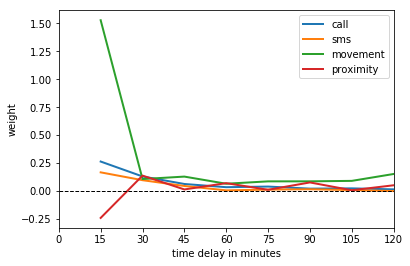

In [10]:
# we separate the weight vector in terms of activity types
activities = ('call', 'sms', 'movement', 'proximity')
W_activities = { activity : [] for activity in activities }
for ii, weight in enumerate(W):
    index = ii % 4
    activity = activities[index]
    W_activities[activity].insert(0, weight )

# we plot the weights of each data type
plt.figure()
time = [ 15 * (ii + 1) for ii in range(W.shape[0]//4) ]
for datatype, weights in W_activities.items():
    plt.plot(time, weights, linewidth=2, label=datatype)
plt.plot((0, max(time)), (0, 0), linewidth=1, color='k', linestyle='--')
plt.xlabel('time delay in minutes')
plt.ylabel('weight')
plt.xticks([0] + time)
plt.xlim(0, max(time))
plt.legend()
plt.show()

To interpret the figure, remember that W includes 32 numbers that are constructued from the combination of 8 time delays and 4 activities. The horizontal axis now represent the time delay and the different curves represent the different activities. The large value of the movement curve at 15 minutes shows us that the support for future movement is dominated by current movement. If you are moving right now, then you are likely to be moving in 15 minutes, and if you are not moving right now, then you probably won't in 15 minutes. We see that calling and texting likewise have a positive impact on the support for future movement. However, social proximity in the time window leading up to the prediction window actually has a negative impact on the support. This kind of makes sense - one is less likely to initiate movement, when one is enjoying the company of others. Generally, all any other impact has a small positive impact on the support. The large positive impact of movement at 120 minutes delay is probably due to the effect of classes that last around 2 hours.